### 1. 가속도계, 자기장계 데이터 불러오기

In [3]:
import pandas as pd
import math

acc_df = pd.read_csv("data/galaxyA31-241121-path1/Accelerometer.csv")
mag_df = pd.read_csv("data/galaxyA31-241121-path1/MagnetometerUncalibrated.csv")

In [4]:
len(acc_df), len(mag_df)

(28415, 28412)

In [5]:
# 가속도계와 자기장계의 시간이 불일치하는 데이터 건수
len(set(mag_df["seconds_elapsed"]) - set(acc_df["seconds_elapsed"]))

28412

In [6]:
# 자기장 magnitude 구하기 (norm L2)
mag_df['L2'] = mag_df.apply(lambda x: math.sqrt(x['x']*x['x'] + x['y']*x['y'] + x['z']*x['z']), axis=1 )
mag_df

,time,seconds_elapsed,z,y,x,L2
0,1732178599606424600,0.209425,-184.000000,-14.900001,-44.900002,189.984263
1,1732178599616326000,0.219326,-186.100006,-15.100000,-49.500000,193.161777
2,1732178599626285800,0.229286,-186.800003,-15.700000,-51.400002,194.377703
3,1732178599636355600,0.239355,-187.400009,-15.000000,-51.900002,195.031725
4,1732178599646364000,0.249364,-187.800003,-15.000000,-53.200001,195.765373
...,...,...,...,...,...,...
28407,1732178883716359000,284.319359,-186.900009,-22.800001,-40.600002,192.613119
28408,1732178883726281500,284.329281,-186.900009,-22.900000,-40.600002,192.624982
28409,1732178883736300500,284.339301,-186.900009,-22.900000,-40.600002,192.624982
28410,1732178883746271500,284.349271,-186.900009,-22.900000,-40.600002,192.624982


### 2. 가속도 z축 방향 데이터로 step 딛은 Time 유추하기 (find_peaks)

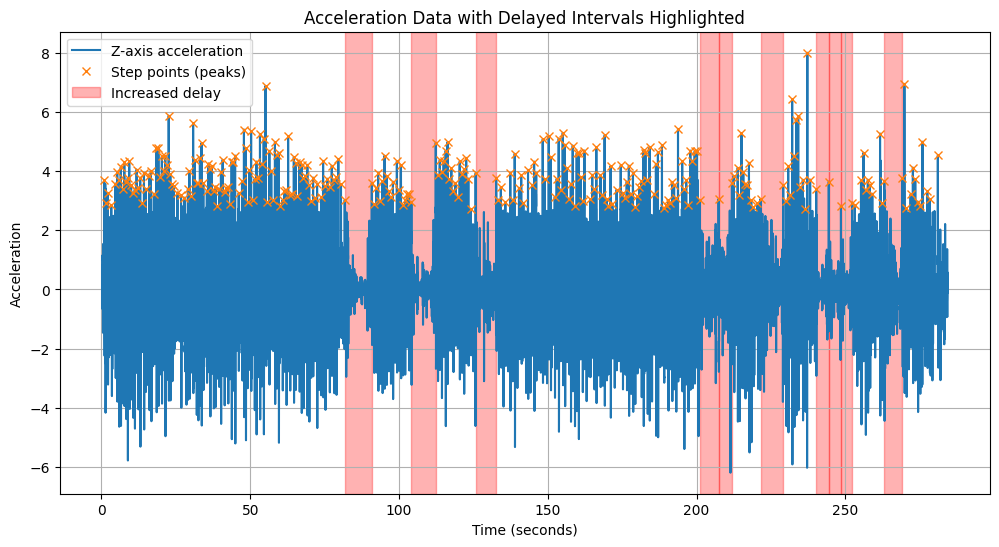

Delayed intervals 발생한 시점: [ 81.75863574 104.16913672 125.75861597 201.07854883 207.4187146
 221.5187207  240.22866968 244.4486709  248.53874268 263.11872534]
Delayed intervals 발생한 시점의 인덱스 번호: [118 137 156 238 239 252 266 267 268 279]


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

time = acc_df["seconds_elapsed"].to_numpy()
z_acc = acc_df["z"].to_numpy()

# 피크 찾기 (=step을 딛은 모든 시점의 인덱스 번호)
peaks, _ = find_peaks(z_acc, height=2.7, distance=50)  # height는 최소 높이, distance는 최소 간격

# 각 피크(step) 간의 시간 간격 구하기
peak_times = time[peaks]  # Convert indices to time
intervals = np.diff(peak_times)  # Time differences between peaks

# Delayed intervals : 피크(step) 간의 시간 간격이 비교적 큰 경우 찾기 (그래프에서 빨간색으로 표시) <- 도착해서 잠시 쉰 지점들
threshold = 5 * np.median(intervals)
delay_indices = np.where(intervals > threshold)[0]  # Indices where delay is significant


# Visualization
plt.figure(figsize=(12, 6))
plt.plot(time, z_acc, label="Z-axis acceleration")
plt.plot(peak_times, z_acc[peaks], "x", label="Step points (peaks)")
for i in delay_indices:
    plt.axvspan(peak_times[i], peak_times[i + 1], color='red', alpha=0.3, label="Increased delay" if i == delay_indices[0] else None)

plt.title("Acceleration Data with Delayed Intervals Highlighted")
plt.xlabel("Time (seconds)")
plt.ylabel("Acceleration")
plt.legend()
plt.grid()
plt.show()

# Output the intervals and delayed sections
print("Delayed intervals 발생한 시점:", peak_times[delay_indices])
print("Delayed intervals 발생한 시점의 인덱스 번호:", delay_indices)

### 3. M-Map 생성 (<x, y, mag>의 리스트)

In [8]:
# 각 지점의 좌표: (1번 지점), (2번 지점), ..., (8번 지점), (1번 지점)
points = [(9,47),(140,47),(144,34),(140,10),(40,10),(40,27),(30,27),(20,37),(9,47)]
# 각 경로의 인덱스 시작과 끝: (1번, 2번), (2번, 3번), ..., (7번, 8번), (8번, 1번)
indices = [(0,118),(119,137),(138,156),(157,238),(240,252),(253,266),(269,279),(280,291)]

print(f"{len(points)=}, {len(indices)=}")

len(points)=9, len(indices)=8


In [9]:
# 각 step 시점에 해당되는 자기장 데이터만 뽑아내기
mag_L2 = mag_df["L2"].to_numpy()
mag_L2_sample = mag_L2[peaks]

In [10]:
# 각 지점의 좌표, 각 경로의 인덱스 시작과 끝 기준으로 좌표별 자기장 값 채우기 (M-Map)

# (예시) "1번 지점" -> "2번 지점" 사이의 mmap 계산 하는 코드
# x = np.linspace(9, 140, 131 + 1)
# y = np.linspace(47, 47, 131 + 1)
# mag = mag_L2_sample[0:131+1]

x,y,mag = [],[],[]

i=0
for start_idx, end_idx in indices:
    x.append(np.linspace(points[i][0], points[i+1][0], end_idx-start_idx+ 1))
    y.append(np.linspace(points[i][1], points[i+1][1], end_idx-start_idx+ 1))
    mag.append(mag_L2_sample[start_idx:end_idx+1])
    i+=1

mmap_df = pd.DataFrame({"X":np.concatenate(x), 
                        "Y":np.concatenate(y),
                        "mag":np.concatenate(mag)})

mmap_df

,X,Y,mag
0,9.000000,47.000000,196.087407
1,10.110169,47.000000,196.453184
2,11.220339,47.000000,195.039429
3,12.330508,47.000000,186.173115
4,13.440678,47.000000,172.497562
...,...,...,...
284,13.000000,43.363636,174.063494
285,12.000000,44.272727,173.194030
286,11.000000,45.181818,171.751949
287,10.000000,46.090909,170.825788


### 4. M-Map 시각화

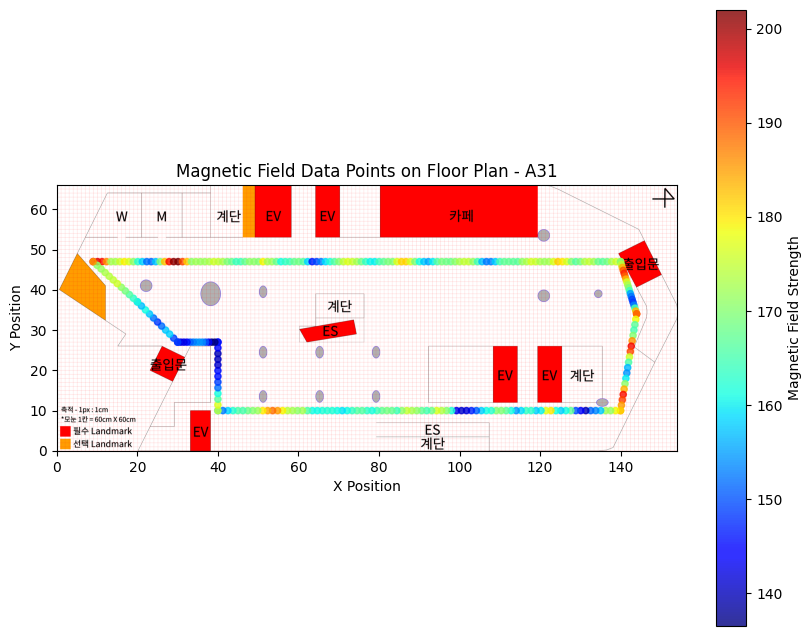

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.colors import Normalize

# 1. 평면도 이미지 불러오기
floor_plan_path = 'floor_plan/KakaoTalk_20241124_152724186_02.png'  # 평면도 이미지 파일 경로
floor_plan = cv2.imread(floor_plan_path)
floor_plan = cv2.cvtColor(floor_plan, cv2.COLOR_BGR2RGB)  # OpenCV는 BGR 포맷이므로 RGB로 변환

# 2. 데이터 분리
x = mmap_df['X'].to_numpy()
y = mmap_df['Y'].to_numpy()
mag = mmap_df['mag'].to_numpy()

# 3. 컬러 매핑 설정
norm = Normalize(vmin=np.min(mag), vmax=np.max(mag))  # 값의 범위 정규화
cmap = colormaps.get_cmap('jet')  # 컬러맵 설정
colors = cmap(norm(mag))  # 값을 컬러맵으로 변환

# 4. 평면도 위에 점만 표시
plt.figure(figsize=(10, 8))

# 평면도 이미지를 뒤집히지 않게 하기 위해 origin='upper'로 설정
plt.imshow(floor_plan, extent=(0, 154, 0, 66), origin='upper') # extent=(x_min, x_max, y_min, y_max)

# 데이터 포인트에 색깔과 크기 적용
scatter = plt.scatter(x, y, c=mag, s=20, cmap=cmap, norm=norm, alpha=0.8)  # scatter의 cmap과 norm 설정

# 컬러바 추가
plt.colorbar(scatter, label='Magnetic Field Strength')  # scatter를 기반으로 컬러바 생성

plt.title('Magnetic Field Data Points on Floor Plan - A31')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.show()


### 5. 보간된 M-Map

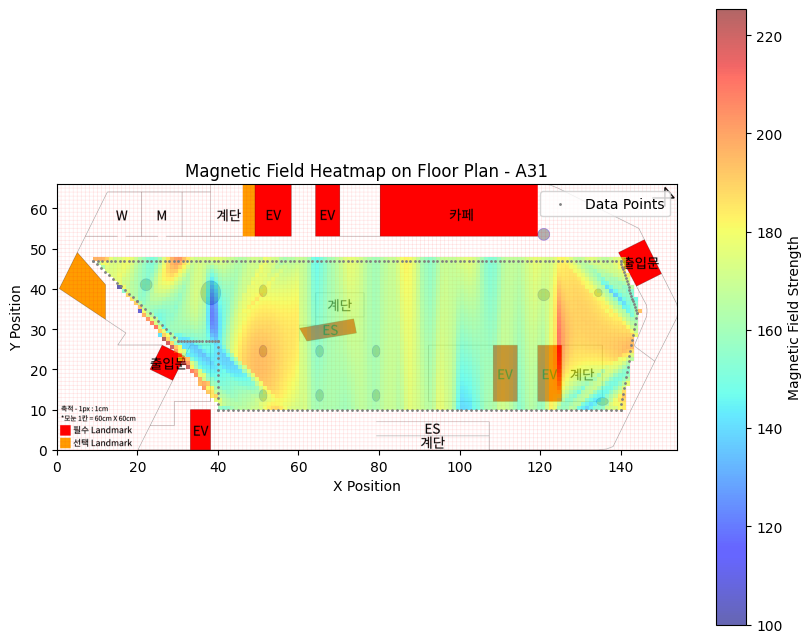

In [12]:
from scipy.interpolate import griddata

x = mmap_df['X'].to_numpy()
y = mmap_df['Y'].to_numpy()
mag = mmap_df['mag'].to_numpy()

# Grid 생성 (Heatmap 인터폴레이션)
grid_x, grid_y = np.mgrid[0:154:1, 0:66:1]  # 원하는 x, y 범위로 Grid 생성
grid_z = griddata((x, y), mag, (grid_x, grid_y), method='cubic')

mmap_grid_df = pd.DataFrame({'X': grid_x.flatten(), 'Y': grid_y.flatten(), 'mag': grid_z.flatten()})


# 시각화 (Heatmap 생성)
plt.figure(figsize=(10, 8))
plt.imshow(floor_plan, extent=(0, 154, 0, 66), origin='upper') # 평면도 표시
plt.imshow(grid_z.T, extent=(0, 154, 0, 66), cmap='jet', alpha=0.6, origin='lower') # Heatmap 오버레이 (alpha로 투명도 조절)

# 컬러바 추가
plt.colorbar(label='Magnetic Field Strength')
plt.scatter(x, y, c='white', edgecolors='grey', s=1, label='Data Points')  # 데이터 포인트 표시
plt.legend()
plt.title('Magnetic Field Heatmap on Floor Plan - A31')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.show()